In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import glob
import os
import matplotlib.pyplot as plt
import time

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from PIL import Image

In [ ]:
# Our CNN class
class CNN(nn.Module):
    def __init__(self, num_classes=10, in_channels=3, conv_layers=None, freeze=True):

        # imports VGG16
        super().__init__()
        vgg = models.vgg16(weights='DEFAULT')

        # chooses how many VGG16 convolutional layers to use
        layers = {0:0, 1:5, 2:10, 3:17, 4:24, 5:31}
        if conv_layers is not None:
            self.cnn = nn.Sequential(*list(vgg.children())[:layers[conv_layers]])
        else:
            self.cnn = nn.Sequential(*list(vgg.children())[:-1])

        # freezes layers if freeze parameter is true
        if freeze:
            for param in self.cnn.parameters():
                param.requires_grad = False

        # passes dummy input to resolve input size issues into classifier
        dummy_input = torch.randn(1, in_channels, 224, 224)
        with torch.no_grad():
             flattened_size = torch.flatten(self.cnn(dummy_input), 1).shape[1]

        # constructs classifier
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(25088, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        # gets last convolutional layer for later Grad-CAM usage
        def _get_last_conv(module: nn.Module) -> nn.Conv2d:
            for m in reversed(list(module.modules())):
                if isinstance(m, nn.Conv2d):
                    return m
            raise ValueError("No Conv2d found in the provided module.")
        self.target_layer = _get_last_conv(self.cnn)
    
    def forward(self, img):
        cnn_feat = self.cnn(img)
        return self.fc(cnn_feat)

In [ ]:
# prints layers of CNN
model = CNN(num_classes=10, conv_layers=None, freeze=True)

print("\n--- CNN Feature Extractor ---")
print(model.cnn)

print("\n--- Fully Connected Classifier ---")
print(model.fc)


--- CNN Feature Extractor ---
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, 

In [ ]:
# our ViT class
class ViT(nn.Module):
    def __init__(self, num_classes, freeze=True):
        # imports existing 16 patch ViT base
        super().__init__()
        self.vit = models.vit_b_16(weights="DEFAULT")

        # freezes layers if need be
        if freeze:
            for param in self.vit.parameters():
                param.requires_grad = False

        # gets ViT output dimension
        vit_output_dim = self.vit.heads.head.in_features
        self.vit.heads = nn.Identity()

        # constructs classifier
        self.fc = nn.Sequential(
            nn.Linear(vit_output_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        # gets first layer norm of the last encoder for Grad-CAM usage
        self.target_layer = self.vit.encoder.layers[-1].ln_1

    def forward(self, img):
        vit_feat = self.vit(img)
        return self.fc(vit_feat)

In [ ]:
# creates training dataset
train_data_dir = 'TRAIN DATASET ROOT DIRECTORY'
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

class_names = train_dataset.classes

print("Train dataset created successfully.")
print("Number of samples:", len(train_dataset))
print("Number of classes:", len(train_dataset.classes))
print("Class names:", class_names)

Train dataset created successfully.
Number of samples: 71694
Number of classes: 3
Class names: ['PE_no_lipids', 'PE_with_lipids', 'PS_no_lipids']


In [ ]:
# creates testing dataset
test_data_dir = 'TEST DATASET ROOT DIRECTORY'
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

class_names2 = test_dataset.classes

print("Train dataset created successfully.")
print("Number of samples:", len(test_dataset))
print("Number of classes:", len(test_dataset.classes))
print("Class names:", class_names2)

Train dataset created successfully.
Number of samples: 40194
Number of classes: 3
Class names: ['PE_no_lipids', 'PE_with_lipids', 'PS_no_lipids']


In [ ]:
# loads datasets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=4)

In [ ]:
# evaluates model accuracy given labeled dataset
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

In [ ]:
# runs the training loop
def training_loop(model, train, test, num_epochs=10, learning_rate=1e-3):
    # tracks training metrics
    epoch_total_loss = []
    epoch_avg_loss = []
    epoch_accuracies = []
    test = []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    start = time.time()

    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0

        for full_img, labels in train:
            full_img, labels = full_img.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(full_img)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            avg_loss = running_loss / len(train)

        epoch_total_loss.append(running_loss)
        epoch_avg_loss.append(avg_loss)
        accuracy = evaluate(model, train)
        epoch_accuracies.append(accuracy)
        
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")
        test_accuracy = evaluate(model = use_model, loader = test_loader)
        test.append(test_accuracy)
        print(f"Epoch {epoch+1}, Total Loss: {running_loss:.4f}, Avg Loss: {avg_loss:.4f} Train Accuracy: {accuracy:.2f}%, Test Accuracy: {test_accuracy} ")

    total_time = time.time() - start
    print(f"\nTraining completed in {total_time/60:.2f} minutes ({total_time:.2f} seconds).")
    return epoch_avg_loss, epoch_total_loss, epoch_accuracies, test

Using device: cuda
Starting training...
Epoch 1 completed in 421.00 seconds
Epoch 1, Total Loss: 39.9198, Avg Loss: 0.0712 Train Accuracy: 98.92%, Test Accuracy: 98.87794198139025 
Epoch 2 completed in 418.28 seconds
Epoch 2, Total Loss: 13.1426, Avg Loss: 0.0234 Train Accuracy: 99.49%, Test Accuracy: 99.4650942926805 
Epoch 3 completed in 422.59 seconds
Epoch 3, Total Loss: 12.9721, Avg Loss: 0.0231 Train Accuracy: 99.53%, Test Accuracy: 99.53475643130815 
Epoch 4 completed in 419.48 seconds
Epoch 4, Total Loss: 5.0341, Avg Loss: 0.0090 Train Accuracy: 99.87%, Test Accuracy: 99.85072398865502 
Epoch 5 completed in 422.30 seconds
Epoch 5, Total Loss: 4.5602, Avg Loss: 0.0081 Train Accuracy: 99.85%, Test Accuracy: 99.82833258695328 
Epoch 6 completed in 416.64 seconds
Epoch 6, Total Loss: 4.1789, Avg Loss: 0.0074 Train Accuracy: 99.90%, Test Accuracy: 99.8631636562671 
Epoch 7 completed in 420.25 seconds
Epoch 7, Total Loss: 2.8101, Avg Loss: 0.0050 Train Accuracy: 99.96%, Test Accuracy

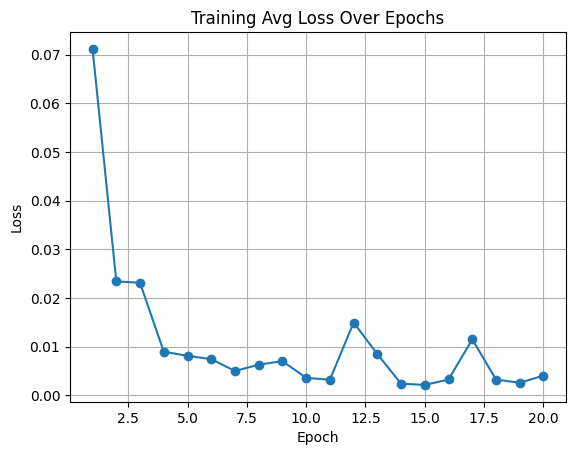

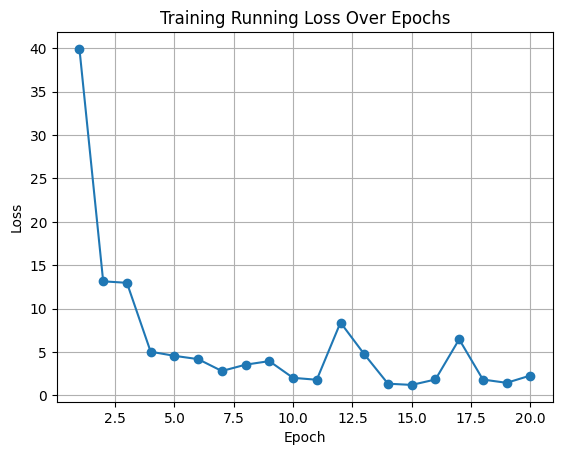

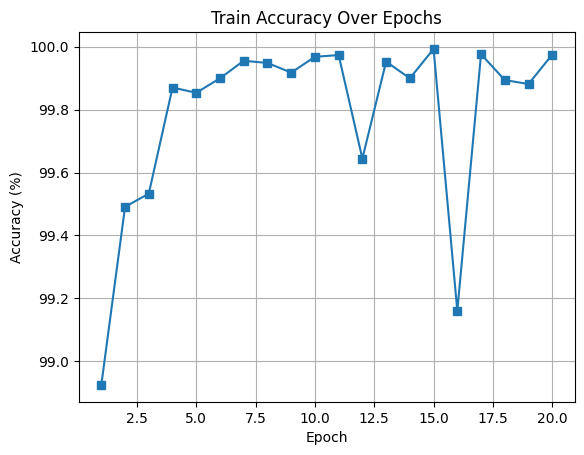

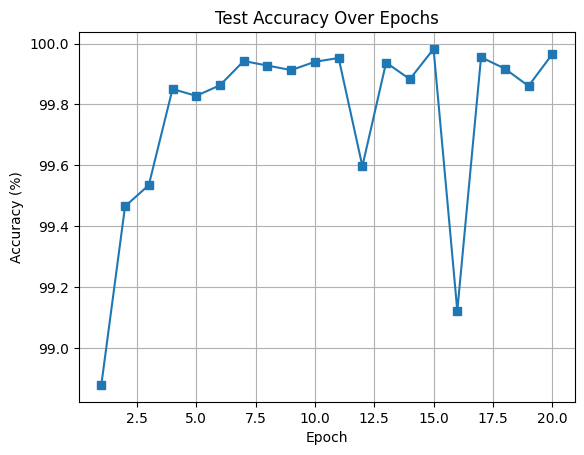

In [ ]:
# CNN training loop
use_model = CNN(num_classes=len(class_names), conv_layers = 2, freeze=False)
WEIGHTS_PATH = 'WEIGHTS FILE'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# if weights file already exists, we load the file
try:
    state_dict = torch.load(WEIGHTS_PATH, map_location=device)
    use_model.load_state_dict(state_dict)
    print(f"Successfully loaded model weights from {WEIGHTS_PATH}")
except FileNotFoundError:
    print(f"Warning: Weights file not found at {WEIGHTS_PATH}. Starting training with random initialization.")
except RuntimeError as e:
    print(f"Error loading state_dict: {e}")
    print("This might happen if the model architecture does not match the saved weights.")
    print("Starting training with random initialization.")

print("Starting training...")
use_model.to(device)

epoch_avg_loss, epoch_running_loss, epoch_accuracies, test = training_loop(model = use_model,
                                               train = train_loader,
                                               test = test_loader,
                                               num_epochs=20, learning_rate = 5e-5)
print("Training finished.")

# saves trained weights to file
try:
    torch.save(use_model.state_dict(), WEIGHTS_PATH)
    print(f"Successfully saved updated model weights to {WEIGHTS_PATH}")
except Exception as e:
    print(f"Error saving model weights: {e}")

# plots training metrics
plt.figure()
plt.plot(range(1, len(epoch_avg_loss) + 1), epoch_avg_loss, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Avg Loss Over Epochs")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, len(epoch_running_loss) + 1), epoch_running_loss, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Running Loss Over Epochs")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, len(epoch_accuracies) + 1), [a for a in epoch_accuracies], marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train Accuracy Over Epochs")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, len(test) + 1), test, marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Over Epochs")
plt.grid(True)
plt.show()

Starting training...
Epoch 1 completed in 940.80 seconds
Epoch 1, Total Loss: 42.7357, Avg Loss: 0.0762 Train Accuracy: 99.06%, Test Accuracy: 98.98989898989899 
Epoch 2 completed in 949.96 seconds
Epoch 2, Total Loss: 17.4400, Avg Loss: 0.0311 Train Accuracy: 99.37%, Test Accuracy: 99.34567348360451 
Epoch 3 completed in 950.65 seconds
Epoch 3, Total Loss: 12.4259, Avg Loss: 0.0221 Train Accuracy: 99.22%, Test Accuracy: 99.18146987112505 
Epoch 4 completed in 945.60 seconds
Epoch 4, Total Loss: 7.6057, Avg Loss: 0.0136 Train Accuracy: 99.74%, Test Accuracy: 99.69896004378764 
Epoch 5 completed in 947.59 seconds
Epoch 5, Total Loss: 6.5112, Avg Loss: 0.0116 Train Accuracy: 99.71%, Test Accuracy: 99.65168930686173 
Epoch 6 completed in 947.78 seconds
Epoch 6, Total Loss: 5.8455, Avg Loss: 0.0104 Train Accuracy: 99.55%, Test Accuracy: 99.49743742847191 
Epoch 7 completed in 949.20 seconds
Epoch 7, Total Loss: 4.8375, Avg Loss: 0.0086 Train Accuracy: 99.75%, Test Accuracy: 99.689008309697

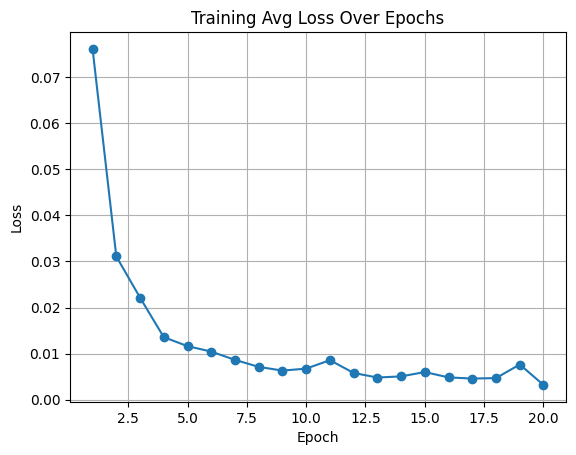

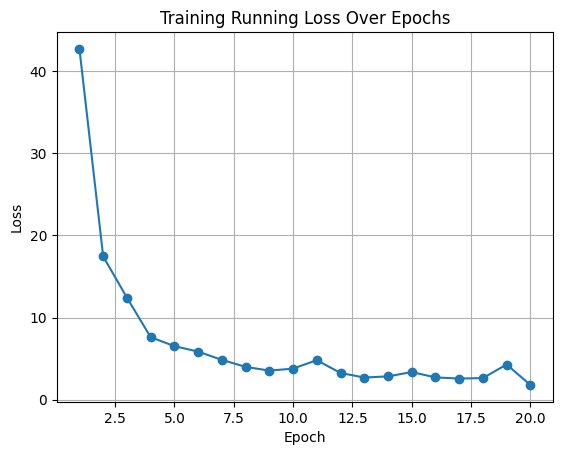

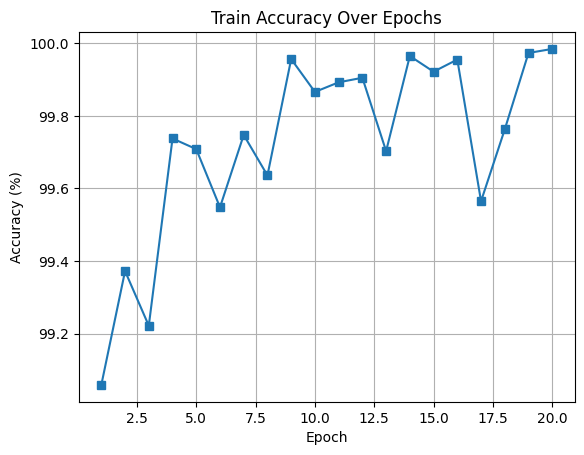

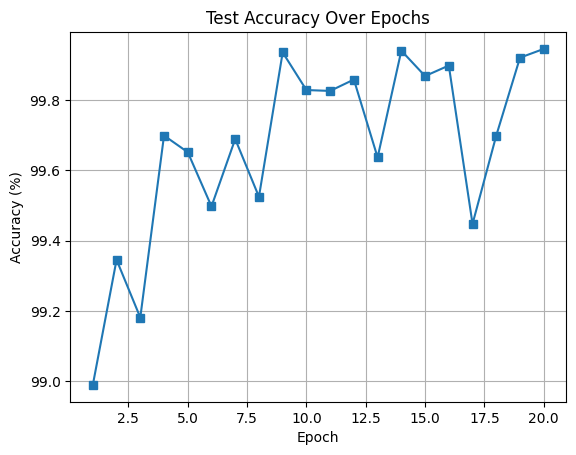

In [ ]:
# same as previous section except for ViT
use_model = ViT(num_classes=len(class_names), freeze=False)
WEIGHTS_PATH = 'WEIGHTS FILE'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    state_dict = torch.load(WEIGHTS_PATH, map_location=device)
    use_model.load_state_dict(state_dict)
    print(f"Successfully loaded model weights from {WEIGHTS_PATH}")
except FileNotFoundError:
    print(f"Warning: Weights file not found at {WEIGHTS_PATH}. Starting training with random initialization.")
except RuntimeError as e:
    print(f"Error loading state_dict: {e}")
    print("This might happen if the model architecture does not match the saved weights.")
    print("Starting training with random initialization.")

print("Starting training...")
use_model.to(device)
epoch_avg_loss, epoch_running_loss, epoch_accuracies, test = training_loop(model = use_model,
                                               train = train_loader,
                                               test = test_loader,
                                               num_epochs=20, learning_rate = 5e-5)

print(f"Test Accuracy: {evaluate(model = use_model, loader = test_loader)}")
print("Training finished.")

try:
    torch.save(use_model.state_dict(), WEIGHTS_PATH)
    print(f"Successfully saved updated model weights to {WEIGHTS_PATH}")
except Exception as e:
    print(f"Error saving model weights: {e}")

plt.figure()
plt.plot(range(1, len(epoch_avg_loss) + 1), epoch_avg_loss, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Avg Loss Over Epochs")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, len(epoch_running_loss) + 1), epoch_running_loss, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Running Loss Over Epochs")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, len(epoch_accuracies) + 1), [a for a in epoch_accuracies], marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train Accuracy Over Epochs")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, len(test) + 1), test, marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Over Epochs")
plt.grid(True)
plt.show()

In [ ]:
# Grad-CAM for CNN

import os, glob
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# file path for visualization
pattern = "VISUALIZATION FILE "  
out_dir = "OUTPUT DIRECTORY"
os.makedirs(out_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model you want to use for visualization. make sure parameters fit model you used
model = CNN(num_classes=len(class_names), conv_layers=2, freeze=False).to(device)
# weight path for the model
WEIGHTS_PATH = 'MODEL WEIGHT PATH'
state_dict = torch.load(WEIGHTS_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval() 

target_layers = [model.target_layer]
cam = GradCAM(model=model, target_layers=target_layers)

# preprocessing (match training size)
IMG_SIZE = 224
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# iterate images
paths = sorted(p for p in glob.glob(pattern) if os.path.isfile(p))

for i, path in enumerate(paths):
    # class name is the parent directory of the image
    class_name = os.path.basename(os.path.dirname(path))
    if class_name not in class_names:
        print(f"[skip] '{class_name}' not in class_names for {path}")
        continue
    target_idx = class_names.index(class_name)
    targets = [ClassifierOutputTarget(target_idx)]
    
    img = Image.open(path).convert("RGB")
    rgb_img_full = np.float32(img) / 255.0                   # (H,W,3)
    input_tensor = preprocess(img).unsqueeze(0).to(device)
    
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]  # (224,224)
    cam_resized = cv2.resize(grayscale_cam, (rgb_img_full.shape[1], rgb_img_full.shape[0]))
    overlay = show_cam_on_image(rgb_img_full, cam_resized, use_rgb=True)

    base = os.path.splitext(os.path.basename(path))[0]
    out_name = f"{base}_gradcam_{class_name}.png"
    Image.fromarray(overlay).save(os.path.join(out_dir, out_name))
    print(f"[saved] {os.path.join(out_dir, out_name)}")


[saved] /global/home/users/eliothuang/visualize_cam_out_frozen_CNN/163707.364_gradcam_PE_no_lipids.png
[saved] /global/home/users/eliothuang/visualize_cam_out_frozen_CNN/163707.872_gradcam_PE_no_lipids.png
[saved] /global/home/users/eliothuang/visualize_cam_out_frozen_CNN/163708.381_gradcam_PE_no_lipids.png
[saved] /global/home/users/eliothuang/visualize_cam_out_frozen_CNN/163708.891_gradcam_PE_no_lipids.png
[saved] /global/home/users/eliothuang/visualize_cam_out_frozen_CNN/163709.401_gradcam_PE_no_lipids.png
[saved] /global/home/users/eliothuang/visualize_cam_out_frozen_CNN/163709.908_gradcam_PE_no_lipids.png
[saved] /global/home/users/eliothuang/visualize_cam_out_frozen_CNN/163710.422_gradcam_PE_no_lipids.png
[saved] /global/home/users/eliothuang/visualize_cam_out_frozen_CNN/163710.940_gradcam_PE_no_lipids.png
[saved] /global/home/users/eliothuang/visualize_cam_out_frozen_CNN/163711.455_gradcam_PE_no_lipids.png
[saved] /global/home/users/eliothuang/visualize_cam_out_frozen_CNN/163711

In [ ]:
# same thing for ViT
import os, glob, math
import numpy as np
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

pattern = "/global/home/users/eliothuang/visualize/*/*"
out_dir = "/global/home/users/eliothuang/visualize_cam_out_unfrozenvit"
os.makedirs(out_dir, exist_ok=True)

torch.set_grad_enabled(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViT(num_classes=len(class_names), freeze=False).to(device)
WEIGHTS_PATH = "/global/home/users/eliothuang/weights/final_unfrozen_ViT_weights.pt"
state_dict = torch.load(WEIGHTS_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

target_layer = model.target_layer

# reshape_transform for ViT (tokens -> HxW)
def vit_reshape_transform(tensor: torch.Tensor):
    if tensor.dim() == 2:
        tensor = tensor.unsqueeze(0)
    assert tensor.dim() == 3, f"Expected [B, Tokens, C], got {list(tensor.shape)}"

    B, T, C = tensor.shape

    def try_hw(tokens_to_drop):
        S = T - tokens_to_drop
        r = int(math.isqrt(S))
        return (r, r) if r * r == S else None

    hw = try_hw(1) or try_hw(2)
    if hw is None:
        raise ValueError(f"Cannot infer HxW: token count {T} not compatible with (T-1) or (T-2) as a square.")
    H, W = hw
    drop = 1 if H * W == (T - 1) else 2

    x = tensor[:, drop:, :]
    x = x.reshape(B, H, W, C).permute(0, 3, 1, 2).contiguous()
    return x

cam = GradCAM(model=model,
              target_layers=[target_layer],
              reshape_transform=vit_reshape_transform)

# reprocessing
IMG_SIZE = 224
preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# iterate images
paths = sorted(p for p in glob.glob(pattern) if os.path.isfile(p))

for path in paths:
    class_name = os.path.basename(os.path.dirname(path))
    if class_name not in class_names:
        print(f"[skip] '{class_name}' not in class_names for {path}")
        continue
    target_idx = class_names.index(class_name)

    img = Image.open(path).convert("RGB")

    # keep original size for overlay; resize only for model input
    rgb_img_full = np.float32(img) / 255.0               
    x = preprocess(img).unsqueeze(0).to(device)
    x.requires_grad_(True)

    targets = [ClassifierOutputTarget(target_idx)]
    grayscale_cam = cam(input_tensor=x, targets=targets)[0] 

    H, W = rgb_img_full.shape[:2]
    cam_resized = cv2.resize(grayscale_cam, (W, H), interpolation=cv2.INTER_CUBIC)

    overlay = show_cam_on_image(rgb_img_full, cam_resized, use_rgb=True)

    base = os.path.splitext(os.path.basename(path))[0]
    out_name = f"{base}_vit_gradcam_{class_name}.png"
    Image.fromarray(overlay).save(os.path.join(out_dir, out_name))
    print(f"[saved] {os.path.join(out_dir, out_name)}")


[saved] /global/home/users/eliothuang/visualize_cam_out_unfrozenvit/163707.364_vit_gradcam_PE_no_lipids.png
[saved] /global/home/users/eliothuang/visualize_cam_out_unfrozenvit/163707.872_vit_gradcam_PE_no_lipids.png
[saved] /global/home/users/eliothuang/visualize_cam_out_unfrozenvit/163708.381_vit_gradcam_PE_no_lipids.png
[saved] /global/home/users/eliothuang/visualize_cam_out_unfrozenvit/163708.891_vit_gradcam_PE_no_lipids.png
[saved] /global/home/users/eliothuang/visualize_cam_out_unfrozenvit/163709.401_vit_gradcam_PE_no_lipids.png
[saved] /global/home/users/eliothuang/visualize_cam_out_unfrozenvit/163709.908_vit_gradcam_PE_no_lipids.png
[saved] /global/home/users/eliothuang/visualize_cam_out_unfrozenvit/163710.422_vit_gradcam_PE_no_lipids.png
[saved] /global/home/users/eliothuang/visualize_cam_out_unfrozenvit/163710.940_vit_gradcam_PE_no_lipids.png
[saved] /global/home/users/eliothuang/visualize_cam_out_unfrozenvit/163711.455_vit_gradcam_PE_no_lipids.png
[saved] /global/home/users/e